# Genetic programming - Classification

In [1]:
import random
import warnings
import operator

import numpy as np
import pandas as pd

from sklearn import metrics

from deap import gp
from deap import creator, base, tools, algorithms

import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

try:
    import pydot
except ImportError:
    pydot = None
    
from IPython.display import Image, display

Iris dataset import and examination.

In [2]:
iris = pd.read_csv("iris.csv")

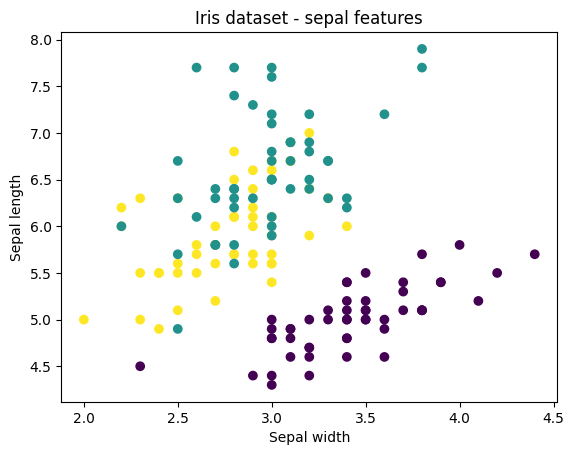

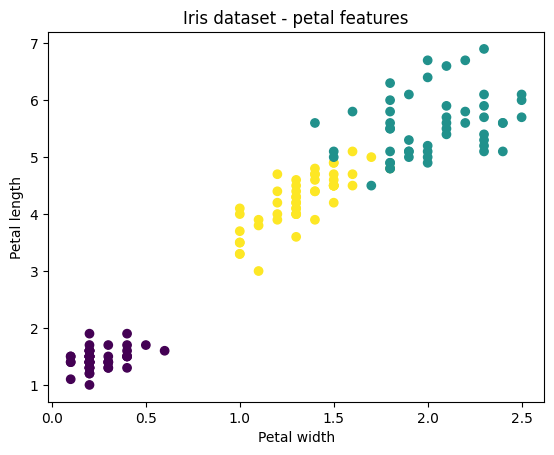

In [3]:
labels = {"Setosa": 0, "Virginica": 1, "Versicolor": 2}
iris_numerical = iris.replace({"variety": labels})

plt.scatter(iris_numerical["sepal.width"], iris_numerical["sepal.length"], c=iris_numerical["variety"])
plt.title("Iris dataset - sepal features")
plt.xlabel("Sepal width")
plt.ylabel("Sepal length") 
plt.show()

plt.scatter(iris_numerical["petal.width"], iris_numerical["petal.length"], c=iris_numerical["variety"])
plt.title("Iris dataset - petal features")
plt.xlabel("Petal width")
plt.ylabel("Petal length") 
plt.show()

Converting the dataset to numpy.

In [4]:
iris.head()

sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa

In [5]:
iris_numpy = iris.to_numpy()
iris_numpy[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Setosa'],
       [5.0, 3.6, 1.4, 0.2, 'Setosa']], dtype=object)

In [6]:
iris_x, iris_y = iris_numpy[:,:-1].astype(float), iris_numpy[:,-1].astype("U")

iris_x[:5], iris_y[:5]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 array(['Setosa', 'Setosa', 'Setosa', 'Setosa', 'Setosa'], dtype='<U10'))

Splitting the dataset to train and test parts.

In [7]:
train_to_test_ratio = 4 / 5
num_of_train_samples = int(train_to_test_ratio * len(iris_y))

permutation = np.random.permutation(len(iris_y))
train_idx = permutation[:num_of_train_samples]
test_idx = permutation[num_of_train_samples:]

x_train, x_test = iris_x[train_idx], iris_x[test_idx]
y_train, y_test = iris_y[train_idx], iris_y[test_idx]

print("Number of train samples:", num_of_train_samples, "| Number of test samples:", len(iris_y) - num_of_train_samples)

Number of train samples: 120 | Number of test samples: 30


Setting the Genetig Programming.

In [8]:
# The set of nodes is named "MAIN", input are four floats (x1, x2, x3, x4), output is one string (y)
pset = gp.PrimitiveSetTyped("MAIN", [float, float, float, float], str)


# Terminals
pset.addTerminal("Setosa", str)
pset.addTerminal("Versicolor", str)
pset.addTerminal("Virginica", str)

pset.addTerminal(0.0, float)
pset.addTerminal(0.2, float)
pset.addTerminal(0.3, float)
pset.addTerminal(0.5, float)
pset.addTerminal(1.0, float)
pset.addTerminal(2.0, float)
pset.addTerminal(3.0, float)
pset.addTerminal(5.0, float)

pset.addTerminal(True, bool)
pset.addTerminal(False, bool)


# Non-terminals
def div(a, b):
    return a / b if b != 0 else 0

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(div, [float, float], float)

def if_then_else(input, output1, output2):
    return output1 if input else output2

pset.addPrimitive(if_then_else, [bool, str, str], str)
# pset.addPrimitive(if_then_else, [bool, bool, bool], bool)

def less_than_or_equal(a, b):
    return a <= b

def greater_than(a, b):
    return a > b

def negation(a):
    return not a

pset.addPrimitive(less_than_or_equal, [float, float], bool)
pset.addPrimitive(greater_than, [float, float], bool)
pset.addPrimitive(negation, [bool], bool)

In [9]:
def get_classes(func, x):
    return list(map(func, *(x.T))) # We round the output value and get the categorization to categories 0, 1, and 2


def fitness(ind, x, y):
    func = toolbox.compile(expr=ind) # We create a function defined by the individual
    vals = get_classes(func, x) # We call the function on data
    accuracy = metrics.accuracy_score(y, vals)
    
    return accuracy, len(ind) # We compute the accuracy and return it along the size of the individual


# Defining classes for the individual
# We want to keep the individual small. This is realized by subtracting a multiple of a size of the individual from the accuracy.
creator.create("FitnessWithRegularization", base.Fitness, weights=(1.0, -0.1))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessWithRegularization)

# Setting the algorithm
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, type_=str, min_=3, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", fitness, x=x_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) 

# Limits to the tree depth
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [10]:
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 500, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max 	min	nevals	std     	avg    	gen	max  	min	nevals	std    
0  	100   	0.34575	0  	0.85	0  	100   	0.153168	1194.99	0  	10145	27 	100   	2417.36
1  	52    	0.467333	1  	0.85	0.233333	52    	0.156523	1149.98	1  	9716 	18 	52    	2117.87
2  	63    	0.55075 	2  	0.85	0.275   	63    	0.160909	1622.42	2  	9718 	18 	63    	2245.75
3  	42    	0.65575 	3  	0.85	0.316667	42    	0.13666 	1723.67	3  	9710 	26 	42    	2088.37
4  	58    	0.724   	4  	0.85	0.316667	58    	0.146791	1977.35	4  	4587 	25 	58    	1763.26
5  	55    	0.809167	5  	0.891667	0.341667	55    	0.0909785	2248.33	5  	4593 	29 	55    	1207.76
6  	56    	0.840083	6  	0.883333	0       	56    	0.0885273	2157.23	6  	4570 	1904	56    	424.649
7  	51    	0.845   	7  	0.883333	0.00833333	51    	0.0900

In [11]:
# Representation of an individual as a tree
def plot_tree(tree):
    nodes, edges, labels = gp.graph(tree)
    nodesDot = list(map(lambda x: pydot.Node(x, label=str(labels.get(x))),nodes))

    g = pydot.Dot(graph_type="graph")
    for node in nodesDot:
        g.add_node(node)
    for f, t in edges:
        edge = pydot.Edge(nodesDot[f], nodesDot[t])
        g.add_edge(edge)

    return g.create_png()

Let's see the representation of the best found individual:

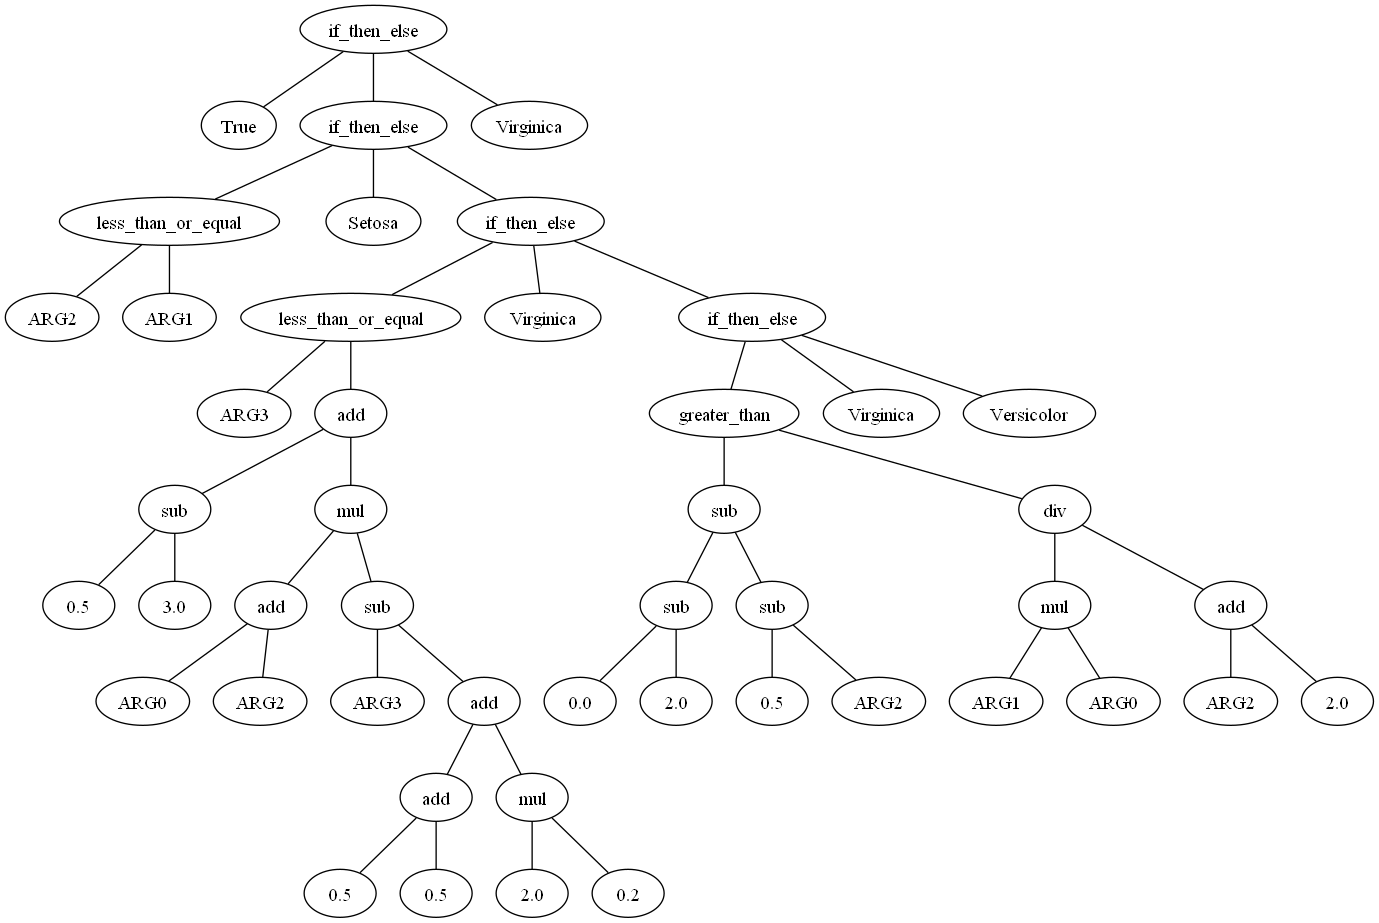

In [12]:
if pydot is None:
    warnings.warn("This display is not available due to a missing optional dependency (pydot)")
    
else:
    display(Image(plot_tree(hof[0])))

And now the accuracy of the best individual and its confusion matrix on the test data

In [13]:
sol = gp.compile(hof[0], pset)

predicted_classes = get_classes(sol, x_test)
accuracy = metrics.accuracy_score(y_test, predicted_classes)
print("Accuracy of the best individual:", accuracy)

Accuracy of the best individual: 0.9666666666666667


Confusion matrix of the best individual from our GP:
[[12  0  0]
 [ 0  8  1]
 [ 0  0  9]]


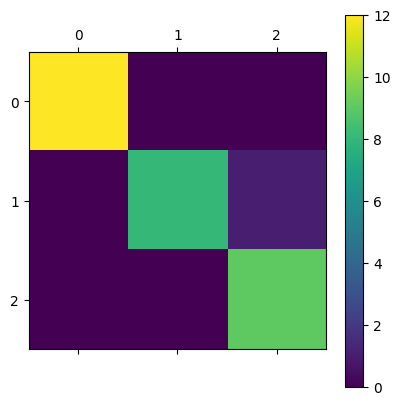

How the confusion matrix looks like for the perfect classifier:
[[12  0  0]
 [ 0  9  0]
 [ 0  0  9]]


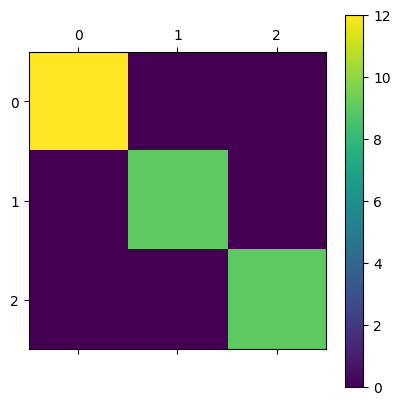

In [14]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted_classes)
print("Confusion matrix of the best individual from our GP:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()

confusion_matrix = metrics.confusion_matrix(y_test, y_test)
print("How the confusion matrix looks like for the perfect classifier:")
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()